## Plot Data

Now, we will also be generate some time series plots using the generated statistic summaries.
- To read the file, we need to define **response_filename** with the concatenated dataset. Here, we are using 'gps_summaries_daily.csv'.

In [1]:
import os
import sys
import glob
import pandas as pd
import yaml

# import hardcoded variables e.g., study name to ID mappings, directory paths, etc. from config file
CONFIG_PATH = "../../config/HOPE_config.yaml"
CONFIG_DIR = os.path.dirname(CONFIG_PATH)

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

data_dir = os.path.abspath(os.path.join(CONFIG_DIR, config["data_dir"]))
raw_data_dir = os.path.abspath(os.path.join(CONFIG_DIR, config["raw_data_dir"]))
metadata_path = os.path.abspath(os.path.join(CONFIG_DIR, config["metadata_path"]))

In [29]:
import matplotlib.pyplot as plt
import os
import pandas as pd

direc = data_dir

# CHANGE depending on which summary you're using -- accwl_summaries_FREQ.csv or gps_summaires_FREQ.cvs
response_filename = 'accel_summaries_daily.csv'
resp_filename = os.path.splitext(response_filename)[0]
resp_freq = resp_filename.split('_')[-1]

path_resp = os.path.join(direc, response_filename)    

# read data
response_data = pd.read_csv(path_resp)

# GPS data (jasmine)
# response_data['Date'] = pd.to_datetime(response_data[['year', 'month', 'day']])

# Accelerometer data (oak)
response_data.rename(columns={'date': 'Date'}, inplace=True)

Here, I'm testing plotting the trajectory for the first ten participants (out of 85)

In [30]:
import numpy as np

np.random.seed(42)
# Define the constant n
n = 10

# Randomly select n unique Beiwe_IDs
random_ids = np.random.choice(response_data['Beiwe_ID'].unique(), size=n, replace=False)

# Subset the dataframe based on the randomly selected IDs
subset_df = response_data[response_data['Beiwe_ID'].isin(random_ids)]

In [13]:
# Check for NA values
has_na = response_data.isnull().any().any()

# Print the result
print(has_na)

# Check for NA values per column
has_na_per_column = response_data.isnull().any()
print(has_na_per_column)

True
Beiwe_ID        False
Date            False
walking_time     True
steps            True
cadence          True
dtype: bool


In [31]:
print(subset_df)
response_data = subset_df

       Beiwe_ID        Date  walking_time   steps   cadence
0      jy8yzsap  2017-04-19           0.0     0.0       NaN
1      jy8yzsap  2017-04-20           NaN     NaN       NaN
2      jy8yzsap  2017-04-21           0.0     0.0       NaN
3      jy8yzsap  2017-04-22           NaN     NaN       NaN
4      jy8yzsap  2017-04-23           NaN     NaN       NaN
...         ...         ...           ...     ...       ...
20681  pwby6ex2  2020-02-22        1171.0  2430.0  2.075235
21430  n7g4xhkg  2020-01-24          13.0    22.0  1.742308
21431  n7g4xhkg  2020-01-25         269.0   483.0  1.799071
21432  n7g4xhkg  2020-01-26           4.0     6.0  1.550000
21433  n7g4xhkg  2020-01-27           0.0     0.0       NaN

[1503 rows x 5 columns]


The data needs to be sorted according to date. The following code will sort and create 4 even time intervals in the plot. 

In [10]:
## Make sure the data is sorted according to date
response_data.sort_values('Date', inplace = True)
response_data.reset_index(drop = True, inplace = True)

def time_series_plot(var_to_plot, ylab = '', xlab = 'Date', num_x_ticks = 1):
    for key, grp in response_data.groupby(['Beiwe_ID']):
        plt.plot(response_data.Date, response_data[var_to_plot], label=key)
    
    # if len(response_data['Beiwe_ID'].unique()) > 1: ## more than one user to plot
    #    plt.plot(response_data.Date, response_data[var_to_plot], c=response_data['Beiwe_ID'].astype('category'))
    # else:
    #    plt.plot(response_data.Date, response_data[var_to_plot]) #just one user
    title = f"Time Series Plot of {var_to_plot}"
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    ## get evenly indices
    tick_indices = [(i * (len(response_data.Date.unique()) - 1)) // (num_x_ticks - 1) for i in range(num_x_ticks) ]
    
    plt.xticks(response_data.Date.unique()[tick_indices])
    plt.show()

In [17]:
import matplotlib.pyplot as plt

## Make sure the data is sorted according to date
response_data.sort_values('Date', inplace = True)
response_data.reset_index(drop = True, inplace = True)

def time_series_plot_mod(var_to_plot, ylab, xlab, num_x_ticks, save_dir=None, freq=resp_freq):
    # Create the directory if it doesn't exist
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Loop over each Beiwe_ID
    for key, grp in response_data.groupby('Beiwe_ID'):
        
        # Create a new figure for each ID
        plt.figure(figsize=(12, 6))
        
        # Plot the data for this specific ID
        plt.plot(grp['Date'], grp[var_to_plot], label=key, marker='o')
        
        # Title and axis labels
        plt.title(f"Time Series Plot of {resp_freq} {var_to_plot} for {key}")
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        
        # Generate tick indices for the subset of dates
        unique_dates = grp['Date'].unique()
        num_ticks = min(num_x_ticks, len(unique_dates))  
        tick_indices = [
            (i * (len(unique_dates) - 1)) // (num_ticks - 1) 
            for i in range(num_ticks)
        ]
        
        # Boolean mask for missing rows
        missing_mask = grp[var_to_plot].isna()
        
        # Apply the ticks with rotation
        plt.xticks(unique_dates[tick_indices], rotation=45)
        
        # Plot missing data points as red X's
        plt.scatter(
            grp.loc[missing_mask, 'Date'],
            [0]*missing_mask.sum(),
            color='red',
            marker='x',
            label='Missing'
        )
        
        # Adjust layout to reduce label clipping
        plt.tight_layout()
        
        # Add legend
        plt.legend()
        
        # Save the plot if save_dir is provided
        if save_dir:
            file_path = os.path.join(save_dir, f"{key}_{var_to_plot}_{freq}_plot.png")
            plt.savefig(file_path)
        
        # Show the plot for this ID
        plt.show()
        plt.close()

In [55]:
def time_series_plot_overlay(var_to_plot_list, ylab, xlab, num_x_ticks, save_dir=None, data_stream=None, freq=resp_freq):
    # Create the directory if it doesn't exist
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Loop over each Beiwe_ID
    for key, grp in response_data.groupby('Beiwe_ID'):
        
        # Create a new figure for each ID
        plt.figure(figsize=(12, 6))
        
        # Track if "missing" label has been added
        missing_label_added = False
        
        # Plot each variable in var_to_plot_list
        for var_to_plot in var_to_plot_list:
            if var_to_plot in grp.columns:
                plt.plot(grp['Date'], grp[var_to_plot], label=f"{var_to_plot}", marker='.', alpha=0.7)
                
                # Boolean mask for missing rows
                missing_mask = grp[var_to_plot].isna()

                # Plot missing data points as red X's
                if missing_mask.any() and not missing_label_added:
                    plt.scatter(
                        grp.loc[missing_mask, 'Date'],
                        [0]*missing_mask.sum(),
                        marker='x',
                        color="black",
                        label="missing"
                    )
                    missing_label_added = True  # Ensure "missing" label is added only once

        # Title and axis labels
        plt.title(f"Time Series Plot of {resp_freq} {data_stream} Variables for {key}")
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        
        # Generate tick indices for the subset of dates
        unique_dates = grp['Date'].unique()
        num_ticks = min(num_x_ticks, len(unique_dates))  
        tick_indices = [
            (i * (len(unique_dates) - 1)) // (num_ticks - 1) 
            for i in range(num_ticks)
        ]
        
        # Apply the ticks with rotation
        plt.xticks(unique_dates[tick_indices], rotation=45)
        
        # Adjust layout to reduce label clipping
        plt.tight_layout()
        
        # Add legend
        plt.legend()
        
        # Save the plot if save_dir is provided
        if save_dir:
            file_path = os.path.join(save_dir, f"{key}_{var_to_plot_list}_{freq}_plot.png")
            plt.savefig(file_path)
        
        # Show the plot for this ID
        plt.show()
        plt.close()

In [49]:
var_to_plot_list

NameError: name 'var_to_plot_list' is not defined

In [ ]:
# import os
# import matplotlib.pyplot as plt

# script_dir = os.path.dirname(__file__)
# results_dir = os.path.join(script_dir, 'Results/')
# sample_file_name = "sample"

# if not os.path.isdir(results_dir):
#     os.makedirs(results_dir)

# plt.plot([1,2,3,4])
# plt.ylabel('some numbers')
# plt.savefig(results_dir + sample_file_name)

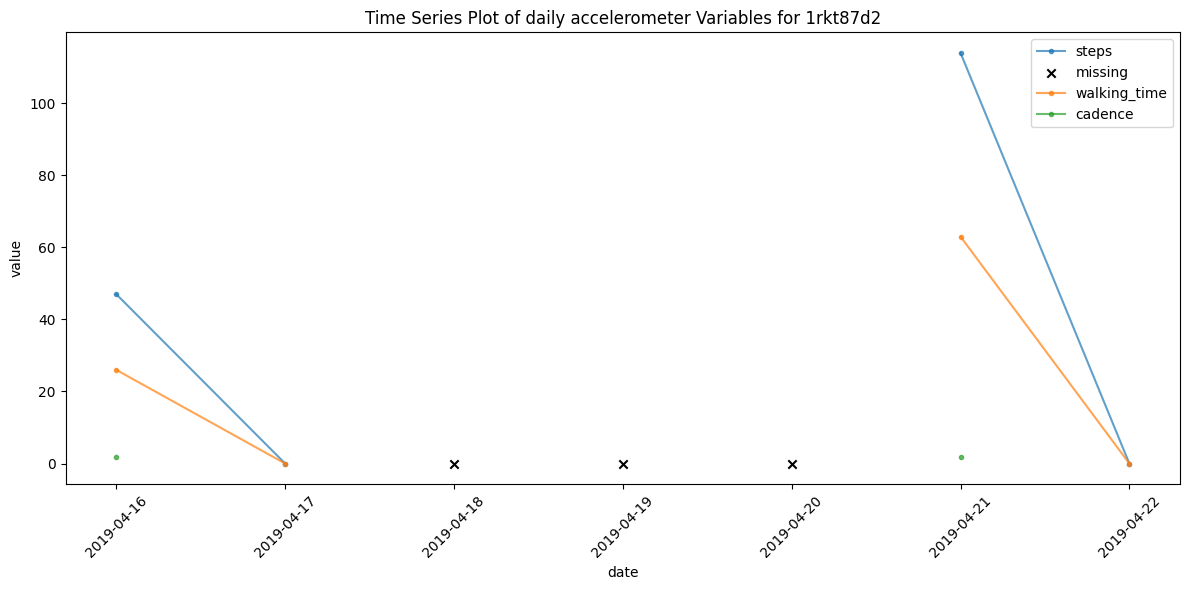

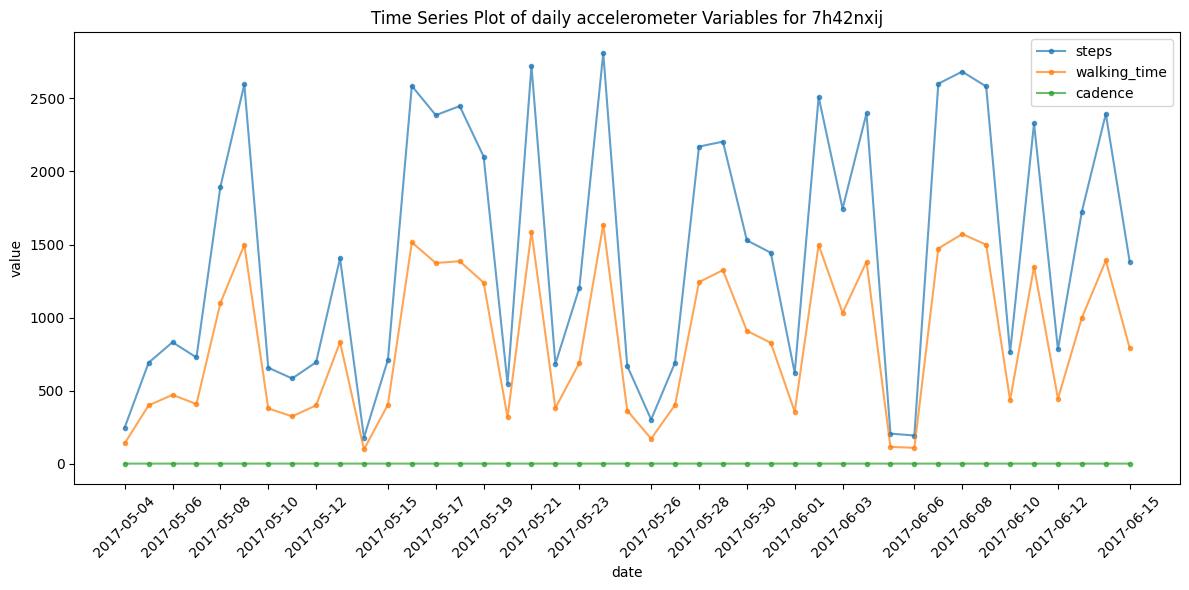

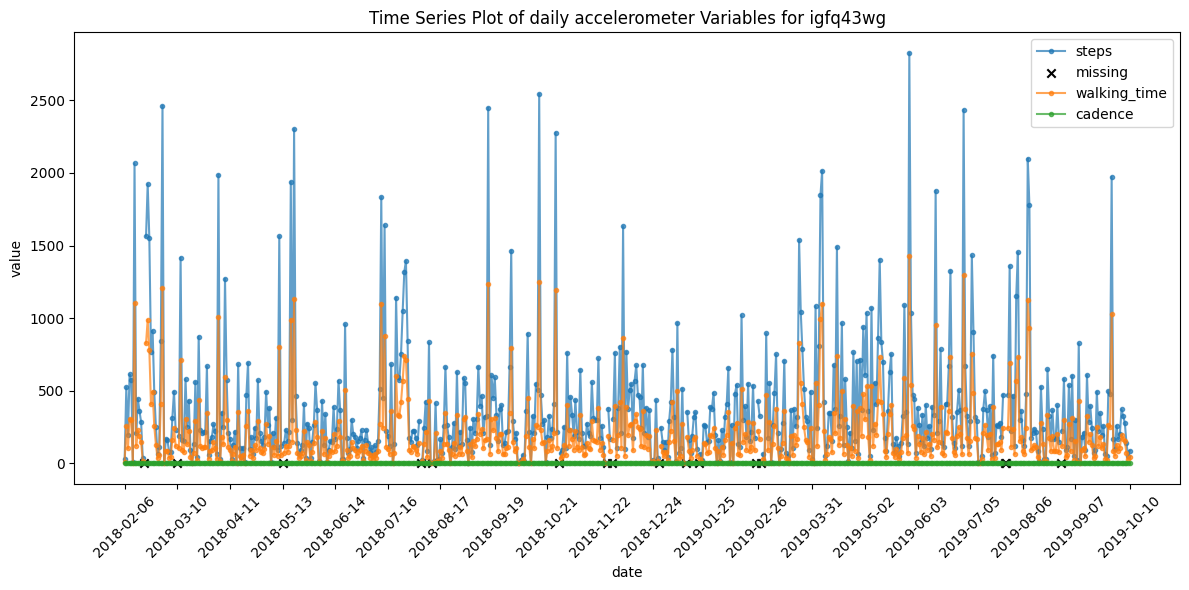

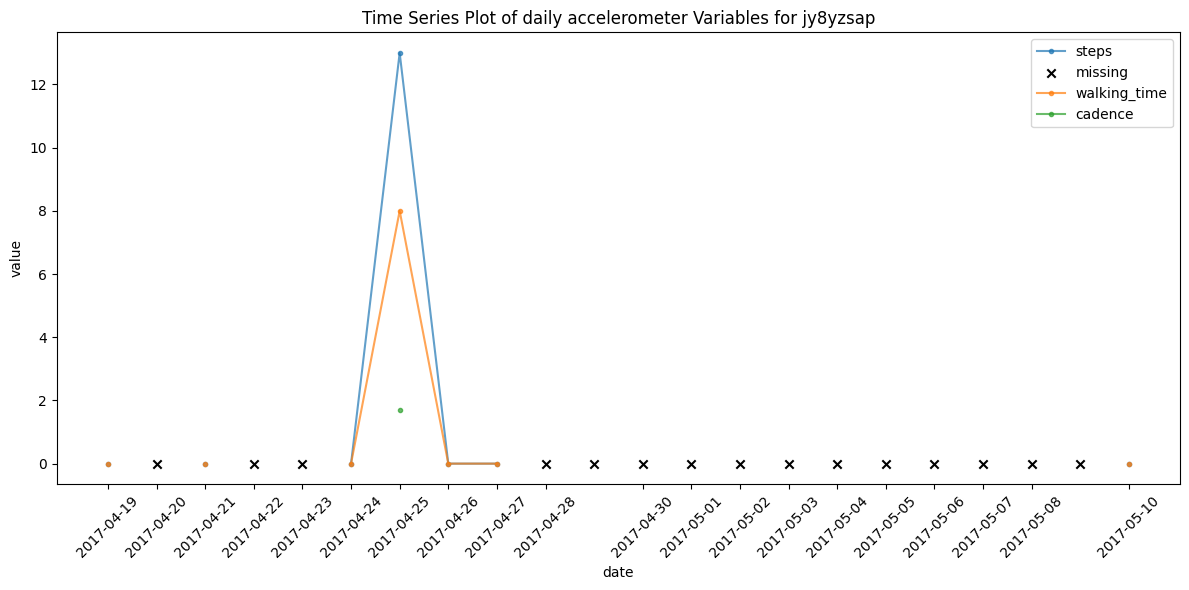

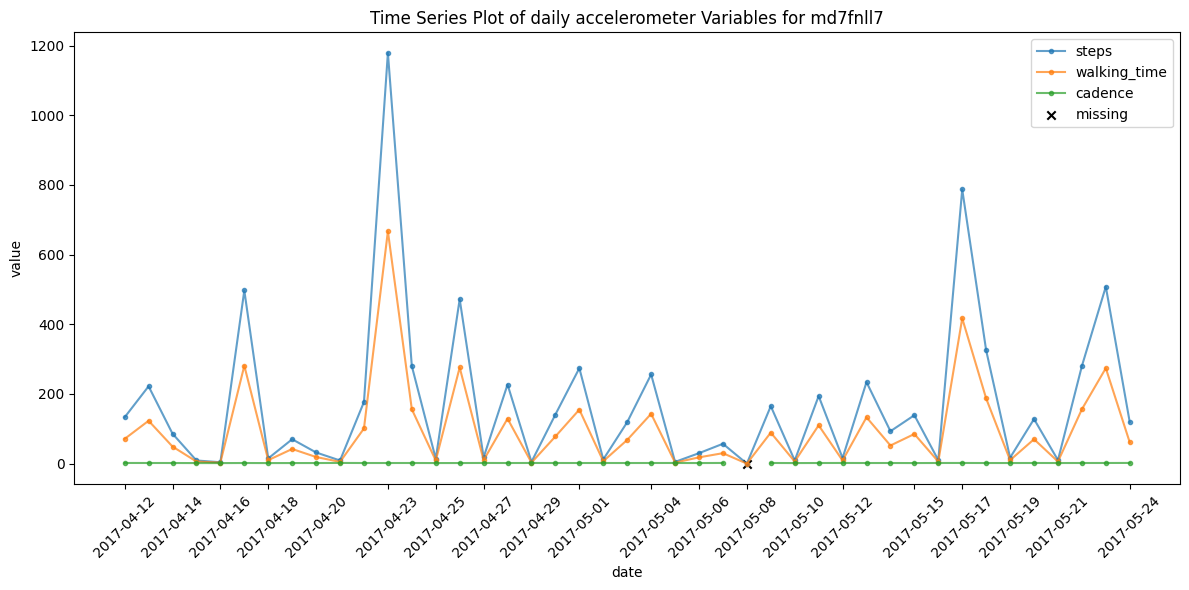

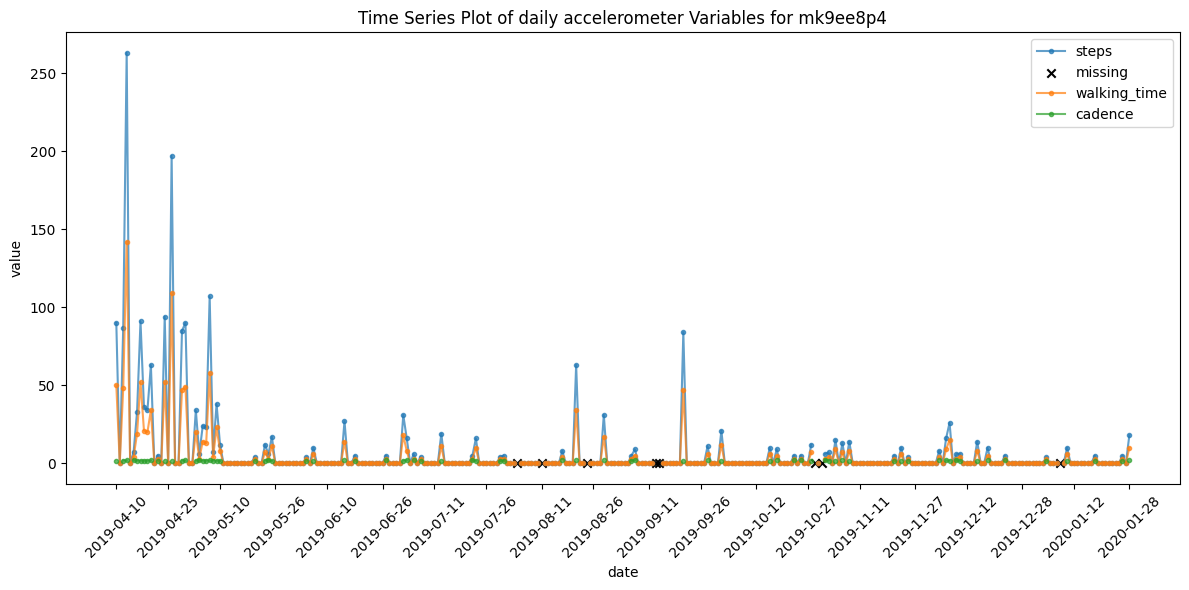

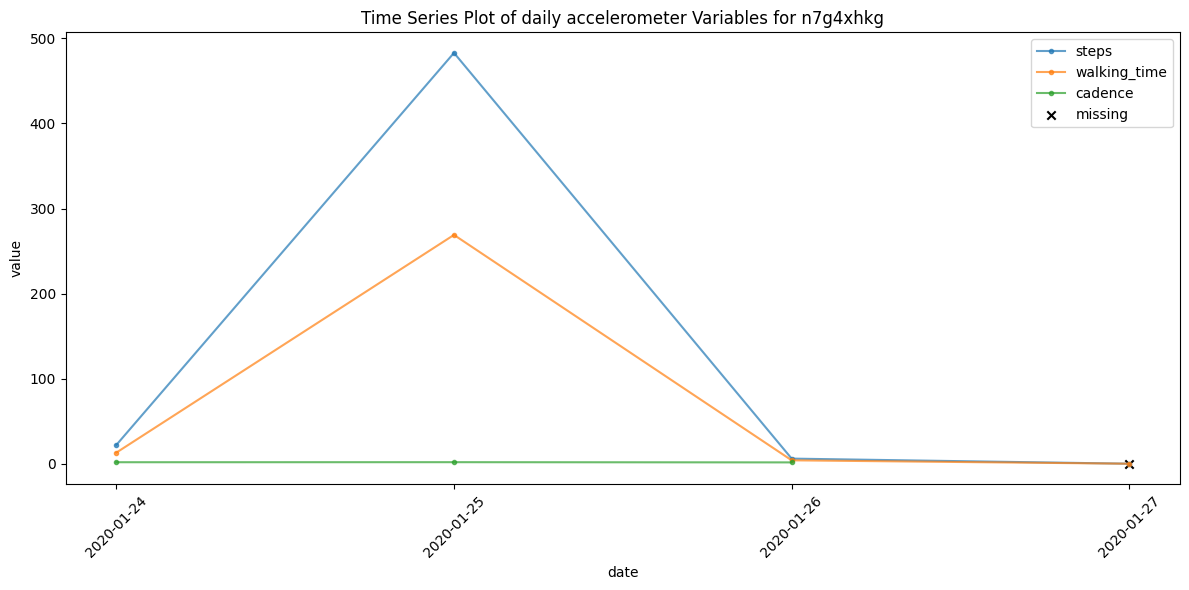

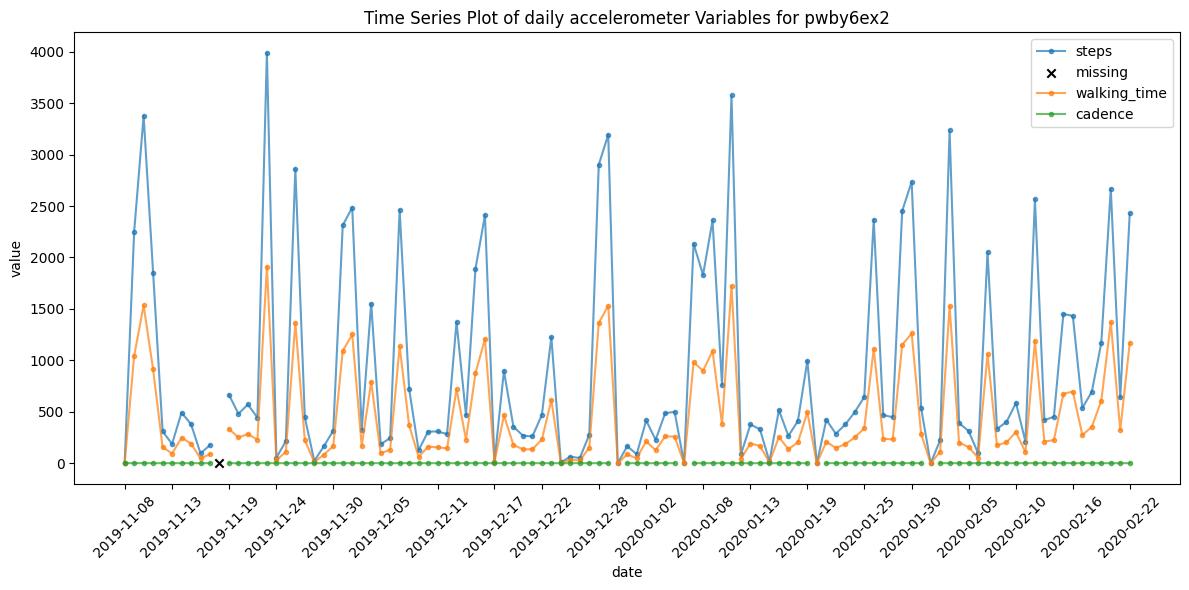

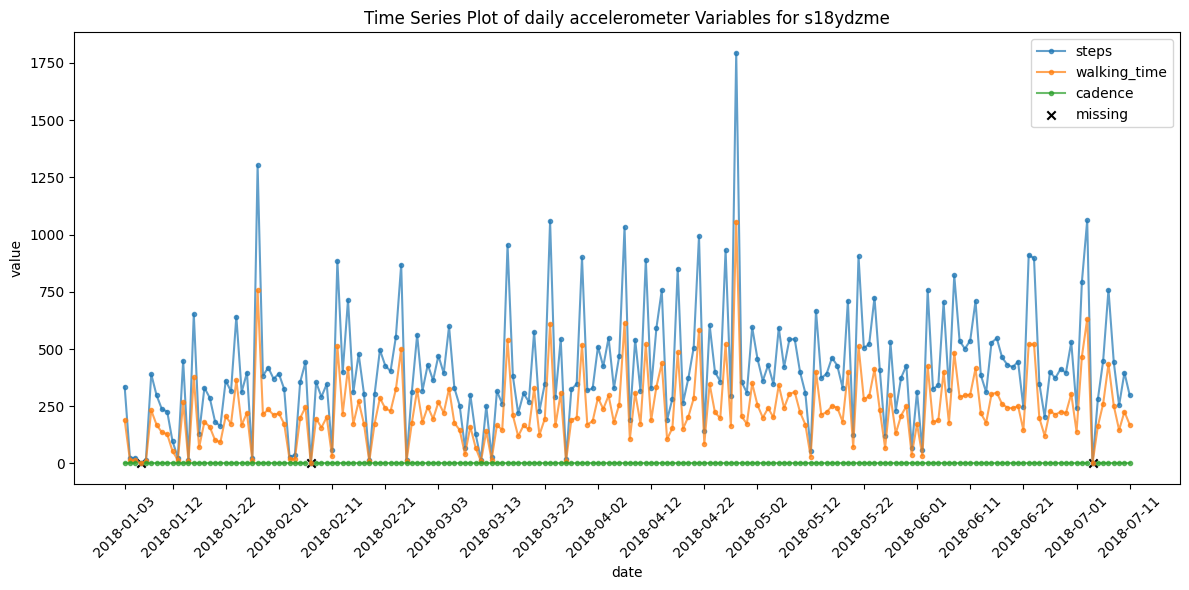

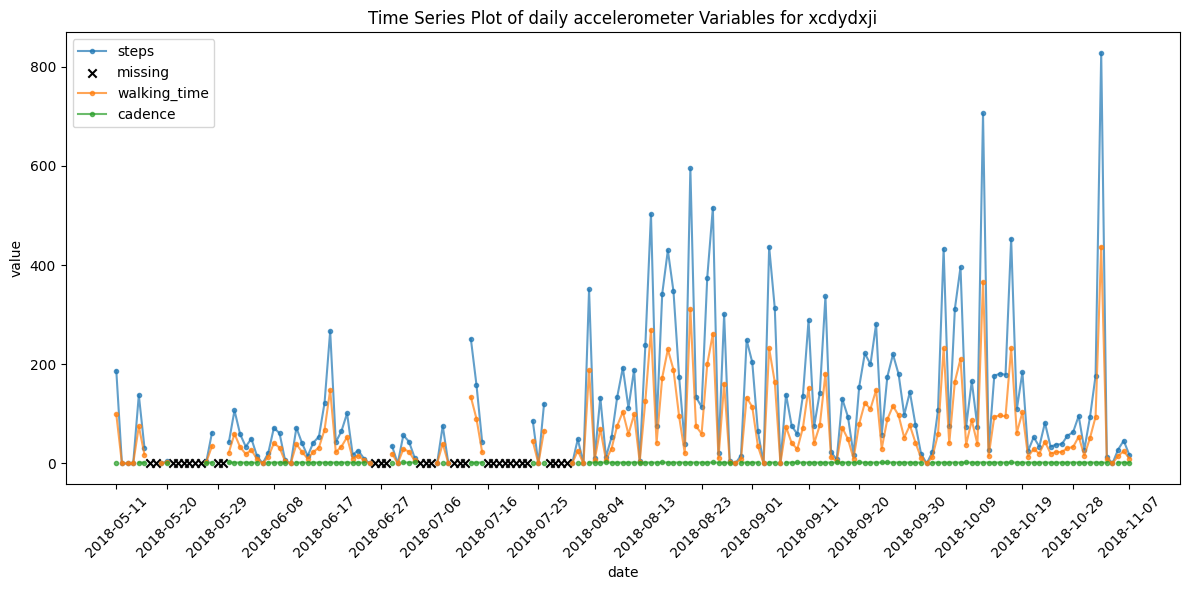

In [56]:
time_series_plot_overlay(var_to_plot_list=["steps", "walking_time", "cadence"], data_stream = "accelerometer", ylab = "value", xlab = "date", num_x_ticks=20)

Plots of daily step count summarie (accelerometer-derived) for the first ten subjects

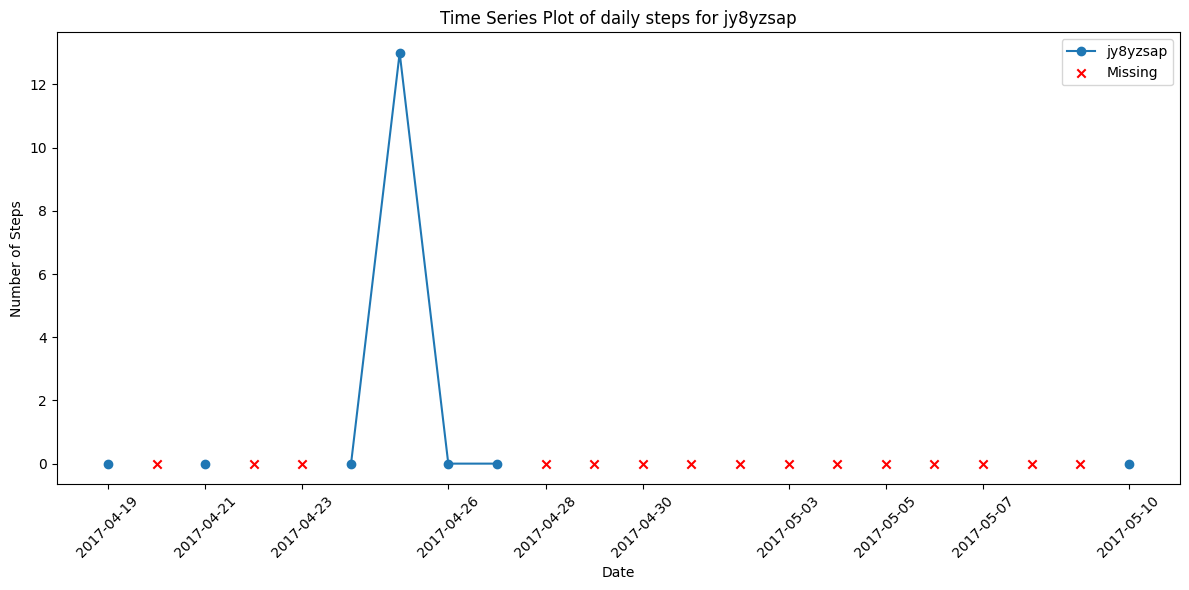

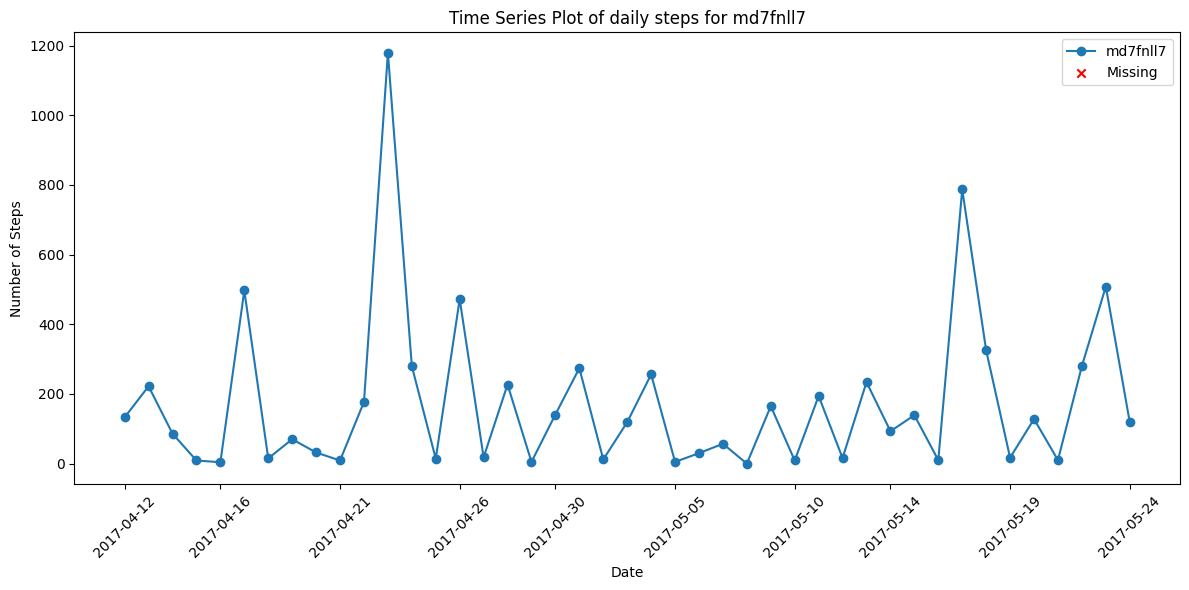

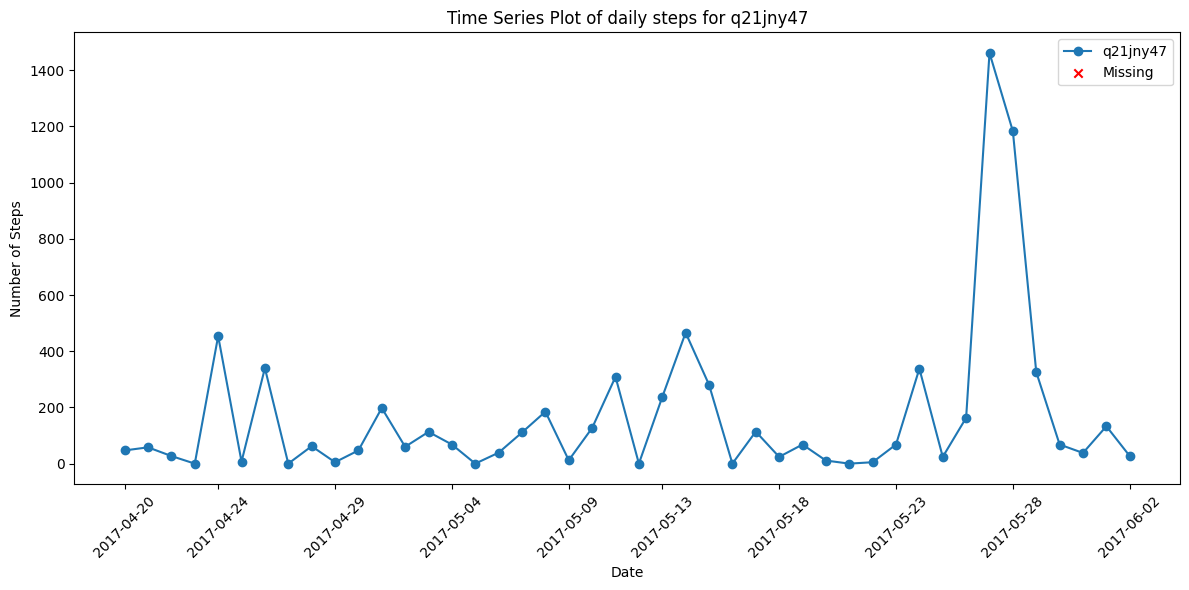

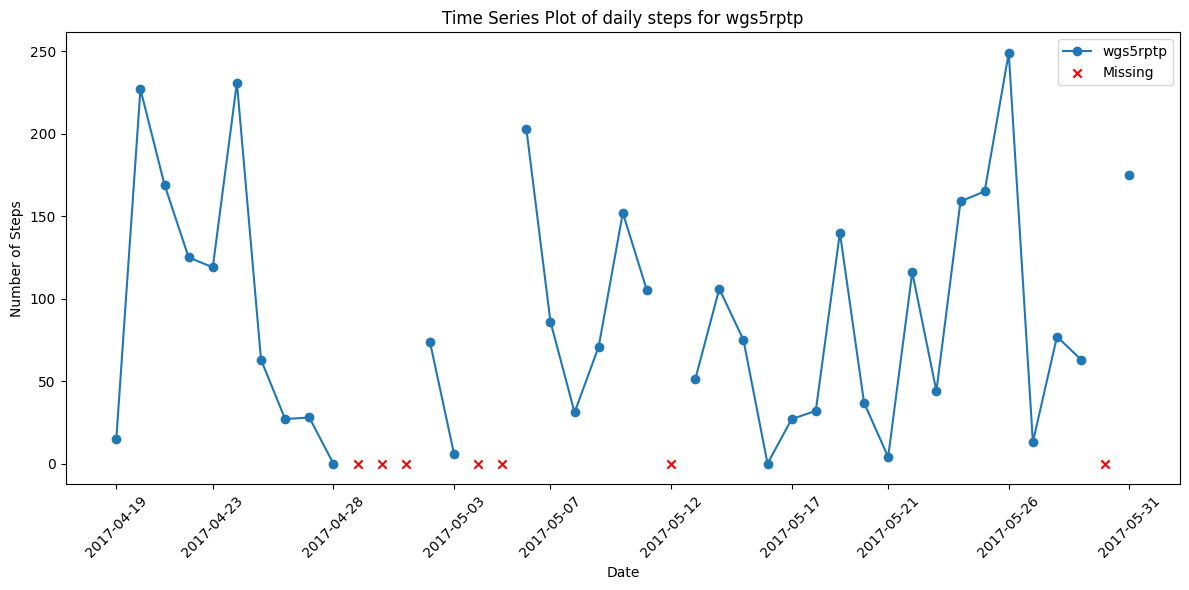

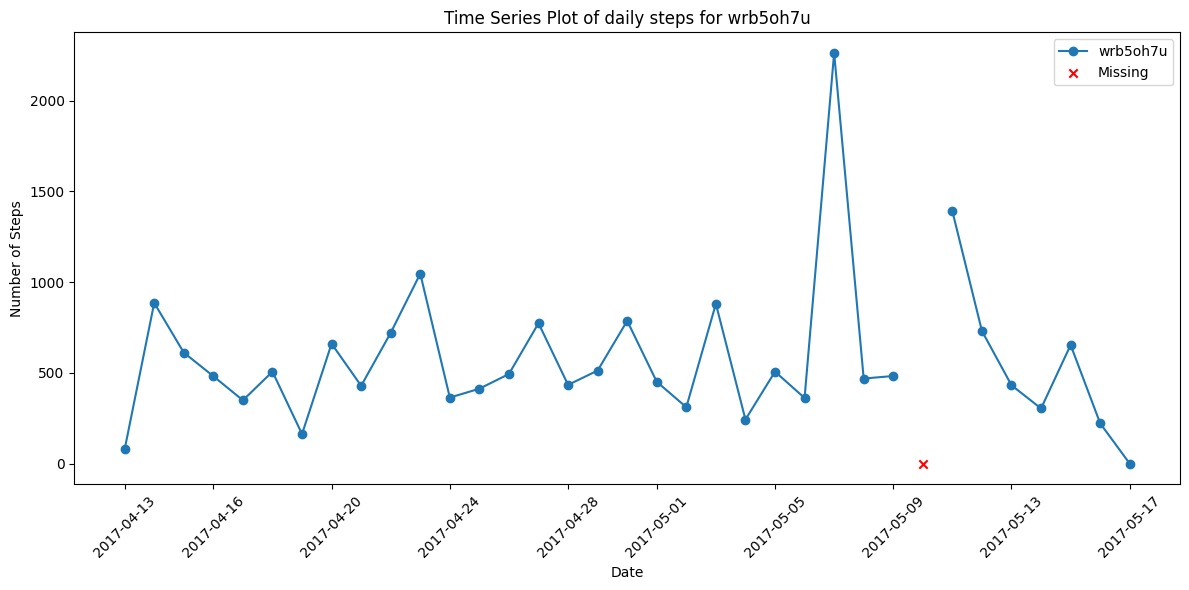

In [18]:
time_series_plot_mod(var_to_plot="steps", ylab="Number of Steps", xlab="Date", num_x_ticks=10)

Plots of daily walking time summary (accelerometer-derived) for the first ten subjects

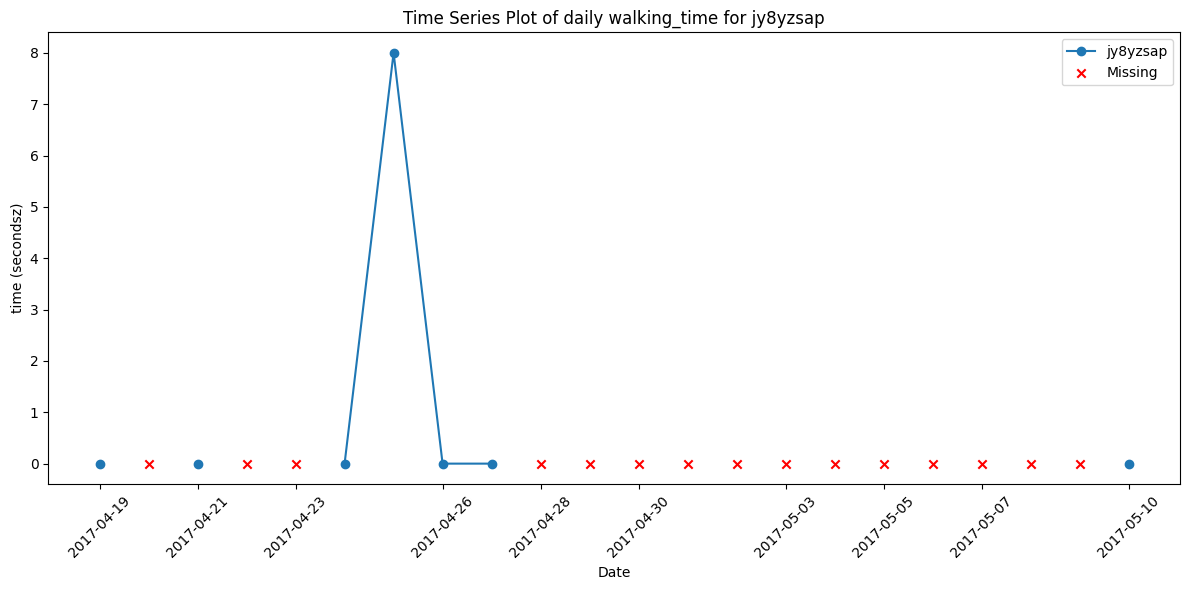

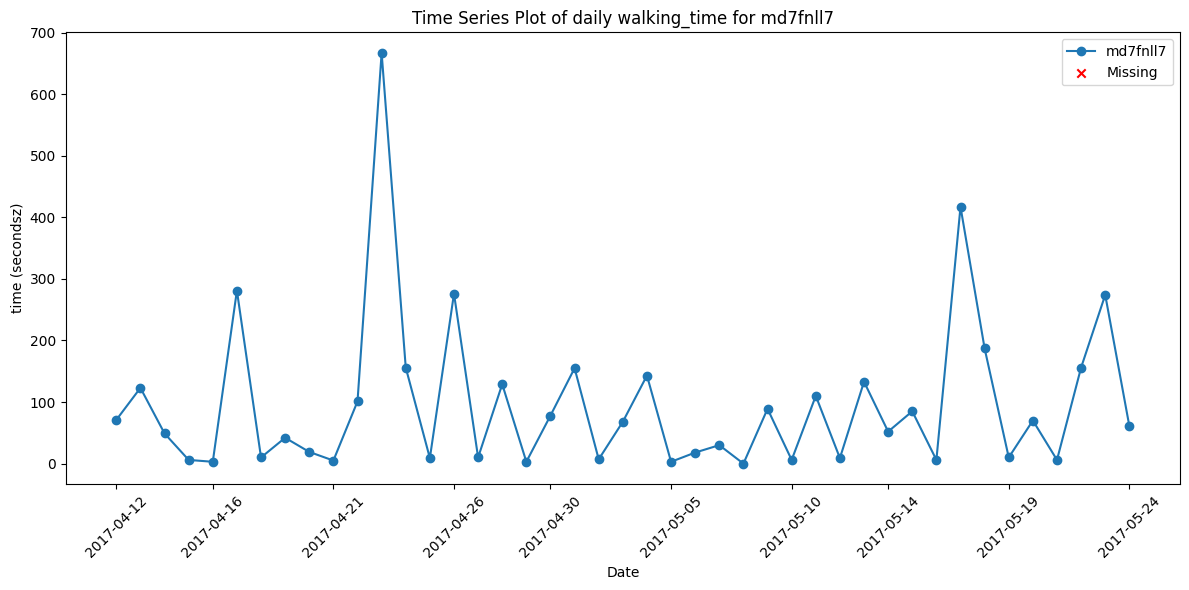

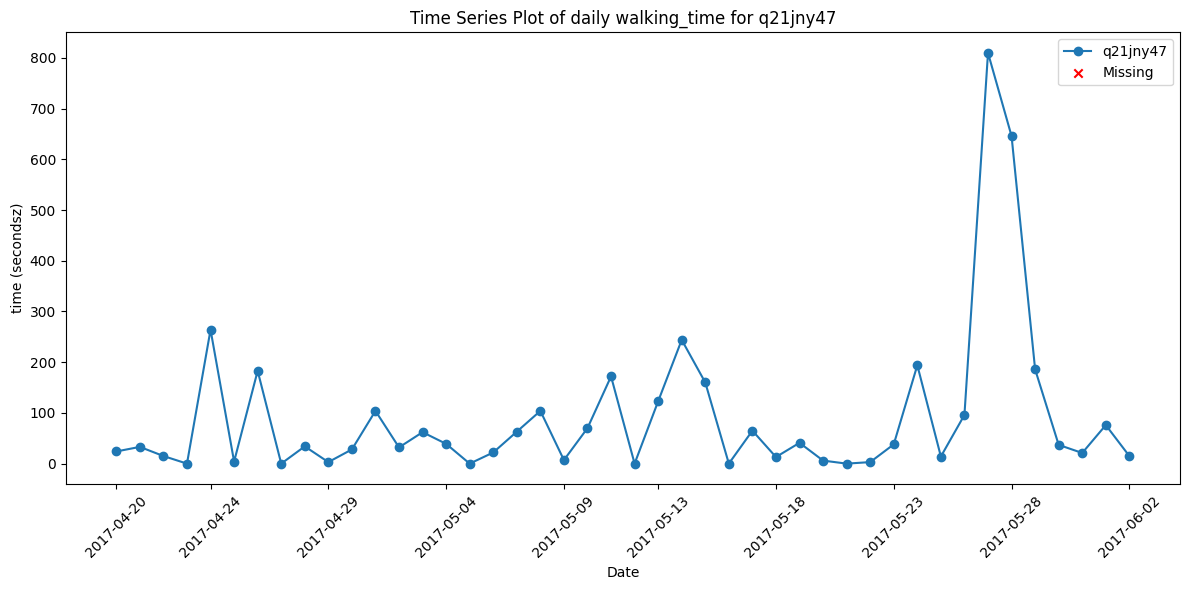

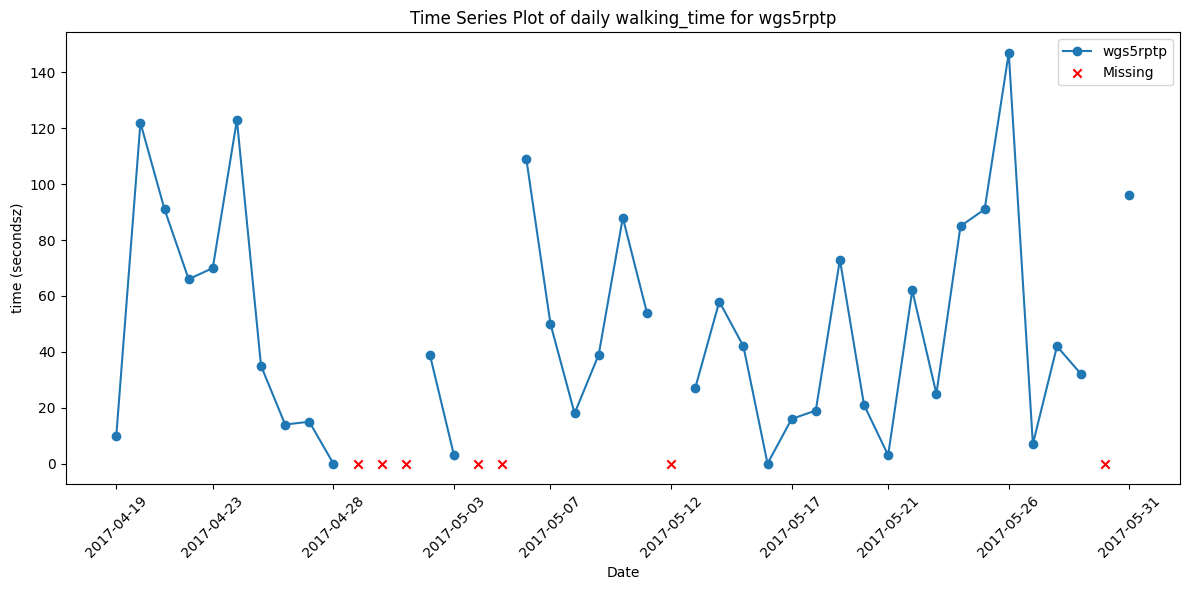

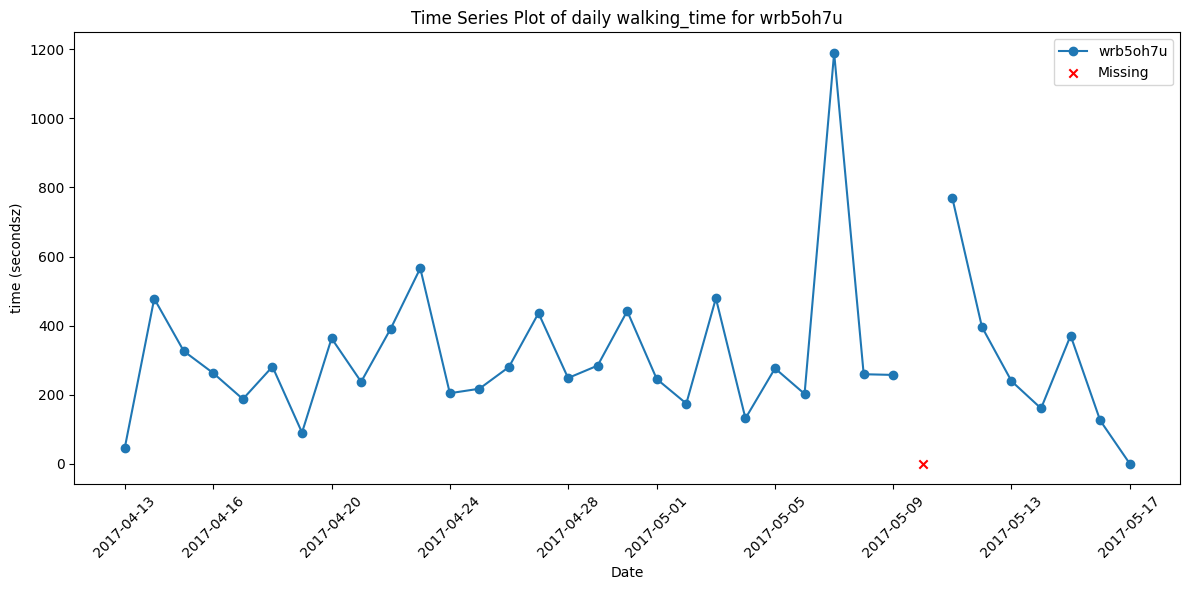

In [23]:
time_series_plot_mod(var_to_plot="walking_time", ylab="time (secondsz)", xlab="Date", num_x_ticks=10)

Plots of daily cadence summary (accelerometer-derived) for the first ten subjects

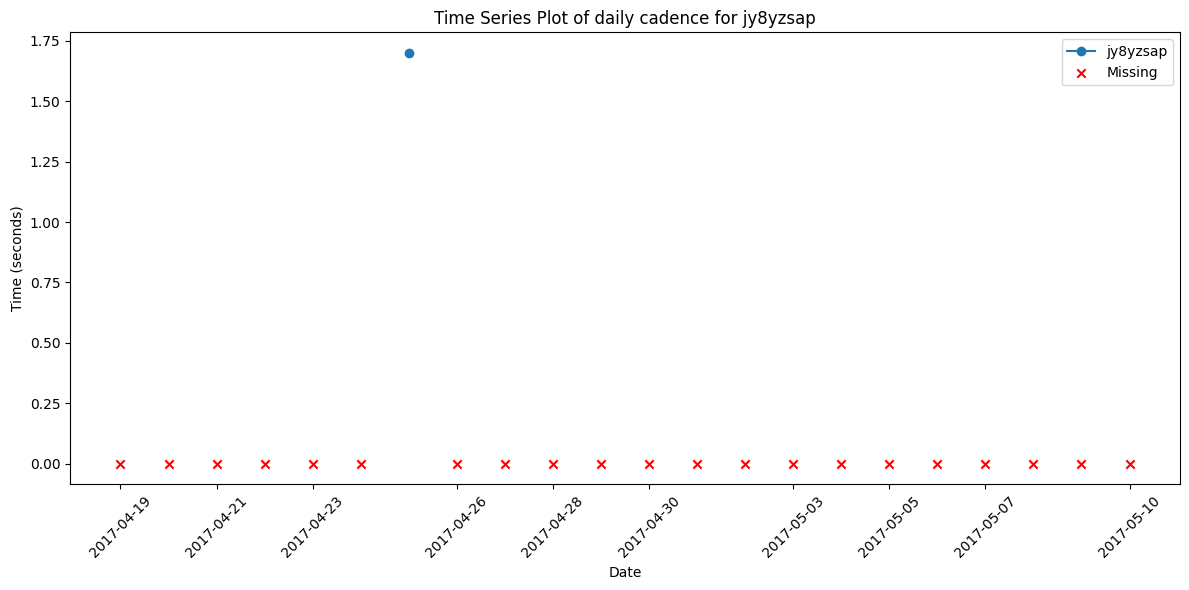

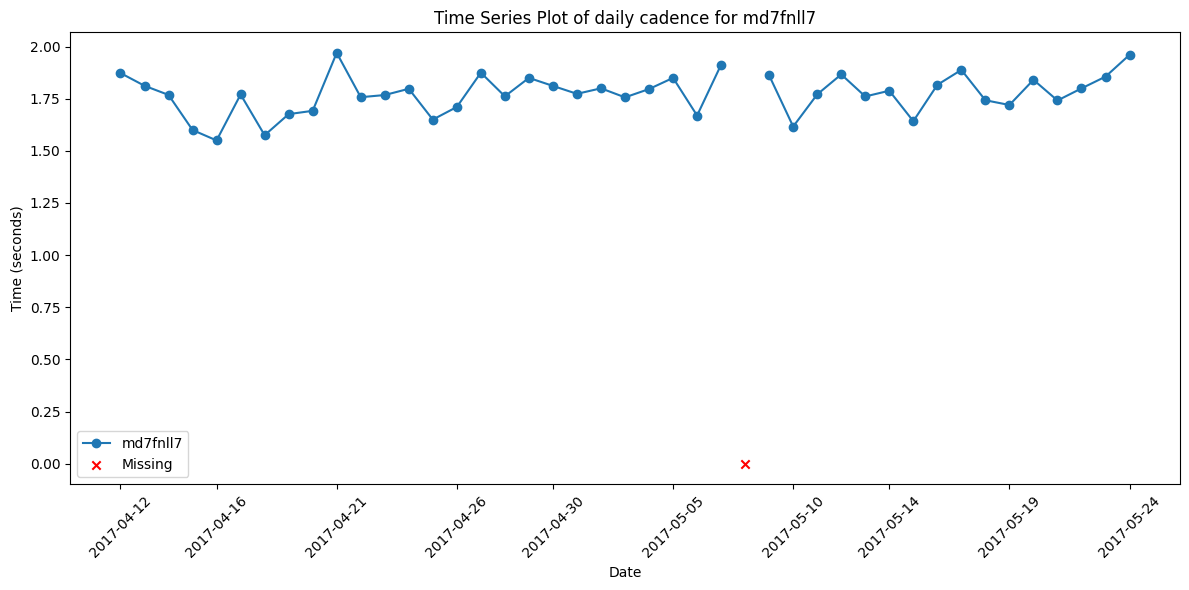

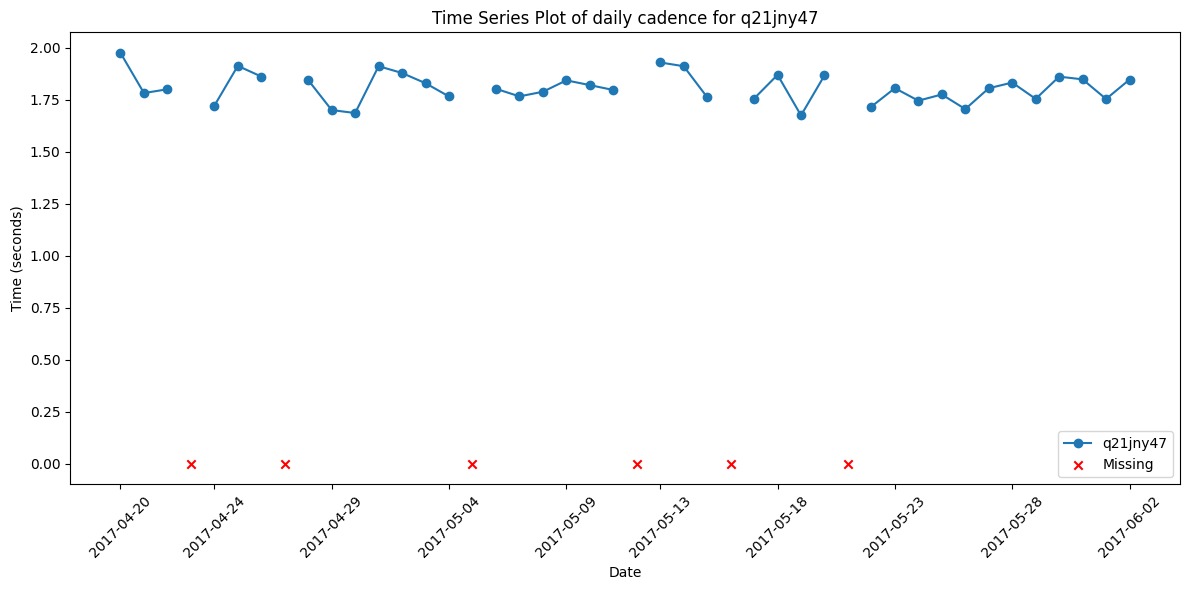

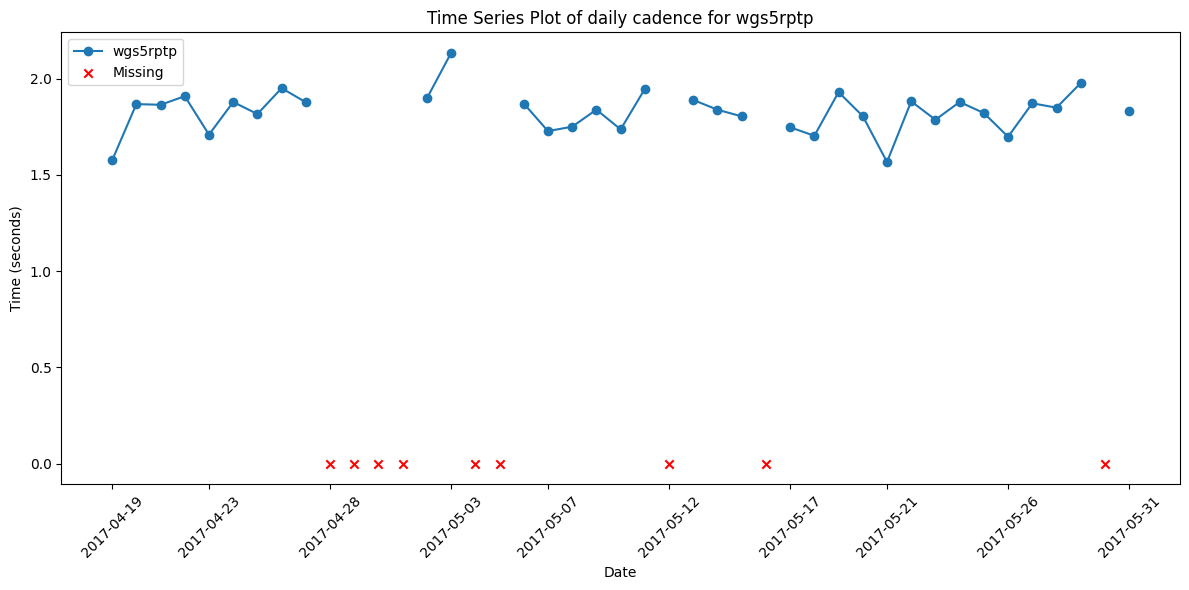

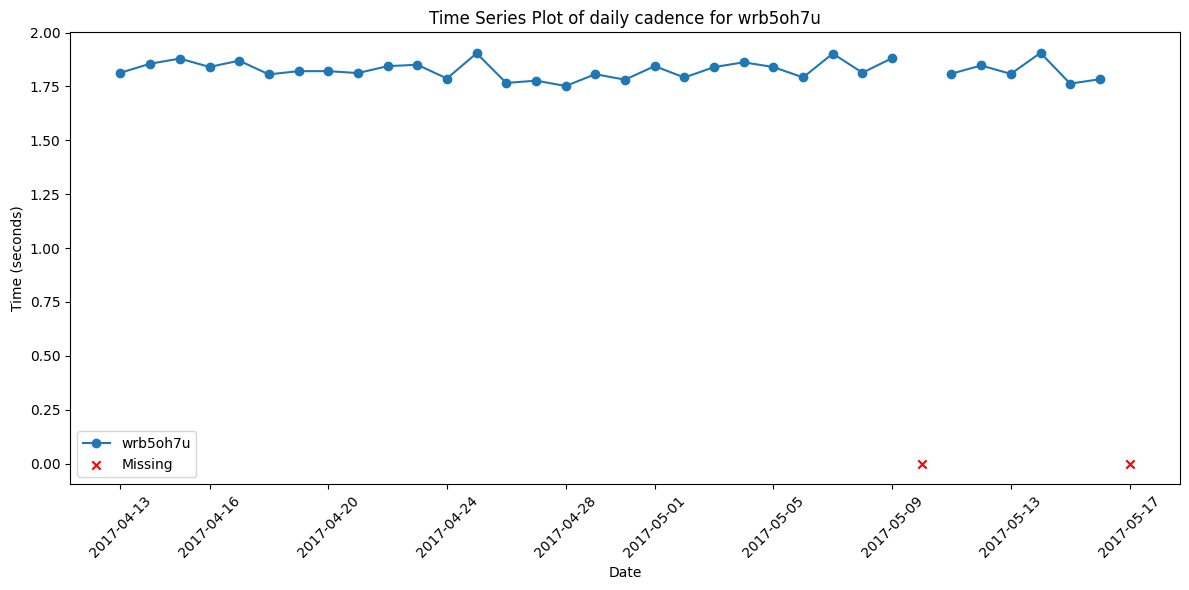

In [22]:
time_series_plot_mod(var_to_plot="cadence", ylab="Time (seconds)", xlab="Date", num_x_ticks=10)

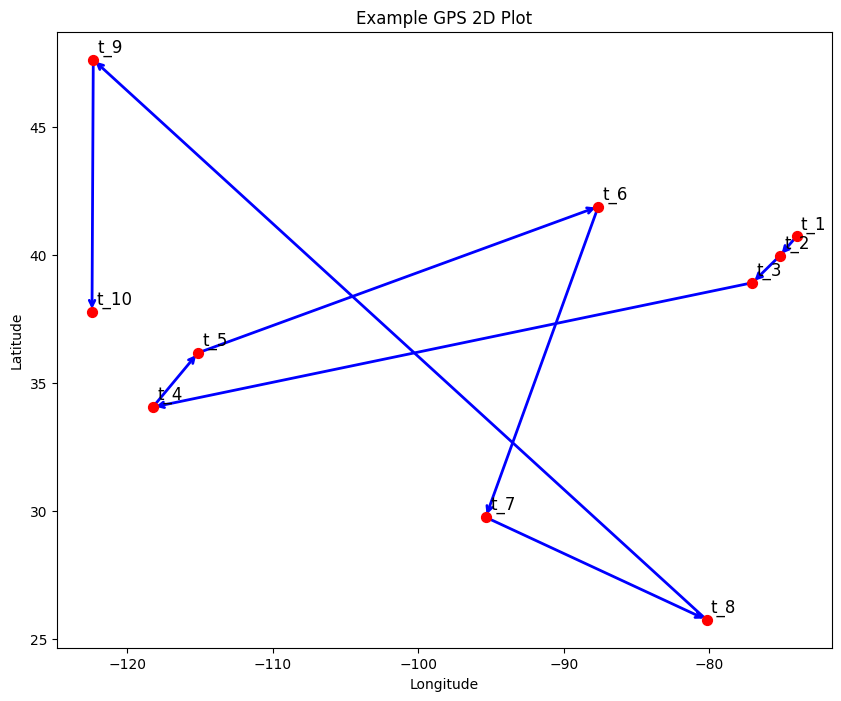

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data including 10 lat, long points and timestamps
data = {
    'latitude': [40.7128, 39.9526, 38.9072, 34.0522, 36.1699, 41.8781, 29.7604, 25.7617, 47.6062, 37.7749],
    'longitude': [-74.0060, -75.1652, -77.0369, -118.2437, -115.1398, -87.6298, -95.3698, -80.1918, -122.3321, -122.4194],
    'timestamp': ['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9', 't_10']
}
df = pd.DataFrame(data)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the points
ax.scatter(df['longitude'], df['latitude'], color='red', s=50, zorder=3)

# Label each point with its timestamp
for index, row in df.iterrows():
    ax.text(row['longitude'] + 0.3, row['latitude'] + 0.3, row['timestamp'], fontsize=12, zorder=4)

# Connect points with arrows in the order of t_1 -> t_2 -> ... -> t_10
for i in range(len(df) - 1):
    start = df.iloc[i]
    end = df.iloc[i + 1]
    ax.annotate(
        '', 
        xy=(end['longitude'], end['latitude']), 
        xytext=(start['longitude'], start['latitude']),
        arrowprops=dict(arrowstyle='->', color='blue', lw=2),
        zorder=2
    )

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Example GPS 2D Plot')

plt.show()


In [24]:
response_data["Beiwe_ID"].unique()

array(['2n18iikg', '2umdx87r'], dtype=object)

- You can now create time series plots using **time_series_plot('variable')**.

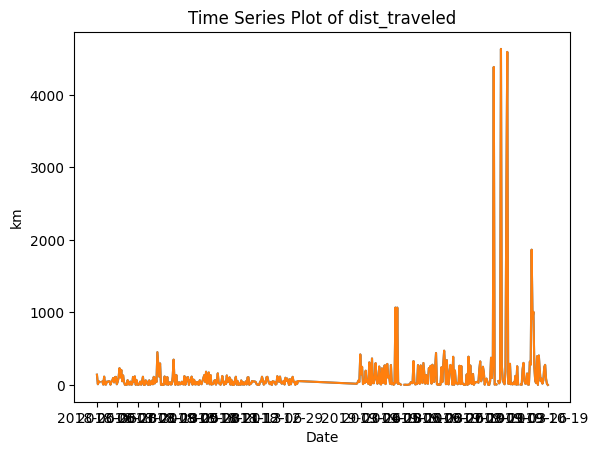

NoneType

In [34]:
type(time_series_plot('dist_traveled', ylab = "km"))


*The output displays a time series plot for the variable, "dist_traveled."*

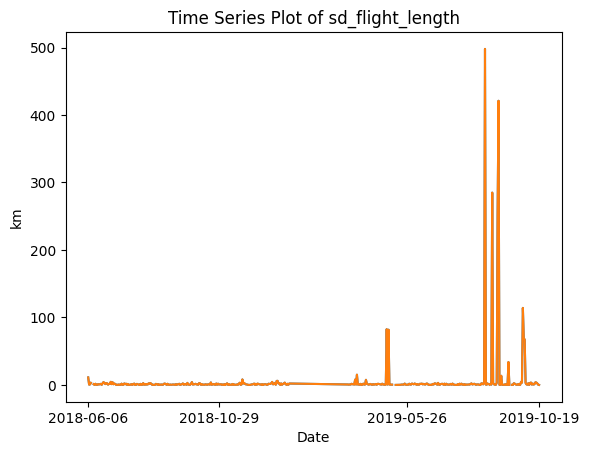

In [19]:
time_series_plot('sd_flight_length', ylab = "km")

*The output displays a time series plot for the variable, "sd_flight_length."*